## Packages for the pipeline

First the general packages for the pipeline

In [76]:
import sys
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, the pipeline itself

You have to write the path to your OmegaLoMo lib directory

In [30]:
sys.path.append('/Users/lbarlet/Desktop/omegaLoMo/lib/')
import core as ca
import createTopo as cT

## Creating Topology

>*database* is the path to your database (Mitab format) 

>*filterIds* correspond to a list of ids which manage to detect an homologue in your Query list



<div class="alert alert-warning">
This might take a while for big database
</div>

In [31]:
database = "/Volumes/arwen/mobi/group/divisome/test_sub.txt"
filterIds = "/Volumes/arwen/mobi/group/divisome/anaBlast/allInR6OnlyIn"

topo = cT.Topology(database, filterIds)
newDic = topo.filter_With(filterIds)

>*newDic* is the filtered and reduced topology of your database

This will be used later to construct the **OmegaMatrix**

In [32]:
print newDic

{'P60174': ['P08047', 'P00533', 'Q9Y234', 'Q9GZR7'], 'Q8CK83': ['P01857', 'O94842', 'P29401', 'Q9ULX6', 'Q86WJ1'], 'A0A0H2UNG3': ['A0A0H2UNW4', 'A0A0H2UNW4', 'A0A0H2UNW4', 'A0A0H2UNW4'], 'P32912': ['P39981'], 'P41092': ['Q9VM49', 'Q9W2M5', 'Q9VR29', 'Q7K3Z6', 'P54623', 'Q9VRS6', 'Q9VVU4', 'Q29R10'], 'Q9W2M5': ['O46100', 'P29613', 'Q9VMV9', 'Q9VEN1'], 'P20936': ['P17544', 'Q5NEE2', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10275', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P08581', 'P08581', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P10721', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'P08581', 'Q92574', 'P01112'], 'O83429': ['O83887'], 'P31016': ['P28572', 'P28572', 'P28572-2', 'P28572-2', 'P28572-2'], 'Q92574': ['Q14457', 'Q16539', 'Q16

## Processing data

Here, you have to use the examples files provide in the git depository.

These files correspond to some subset and can be use on this notebook as a quick way to familiarise yourself with the pipeline

>*indexR6* is a list of UniprotId corresponding to the proteome of your organims

>*bean* is a serialized version of a small dataset, corresponding to a topology

>*path* is the path to a directory with some blast.out files (in xml format)

In [106]:
indexR6 = '/Volumes/arwen/mobi/group/divisome/anaBlast/indexR6'

Use the following cell if you use a serialised version

In [107]:
omegaSet = ca.HomegaSet(bean='/Volumes/arwen/mobi/group/divisome/anaBlast/fullIntactInteractionOmega.json',
                        queryIdList=indexR6)

Use the following cell if you start from multiple blast

In [102]:
omegaSet = ca.HomegaSet(path='/Volumes/arwen/mobi/group/divisome/exampleFiles/subset_Blast/',
                        queryIdList=indexR6)

Organising the HomegaSet to an **OmegaMatrix** by deleting template wich doesn't bring back queries of interest. 

The **OmegaMatrix** will project from the template space to a matrix of queries to identify all interactions the queries.

In [108]:
omegaMatrix = ca.OmegaMatrix(topo = newDic, omegaSet = omegaSet)
omegaMatrix.reduceAndVectorInject()
queryTopo = omegaMatrix.project()

   ## Selection of proteins of interest  

>*divR6Known* is a downloaded list from uniprot with the "cell division" GO term selected

<div class="alert alert-info">
    You can check out the list <a href=http://www.uniprot.org/uniprot/?query=taxonomy:%22Streptococcus%20pneumoniae%20(strain%20ATCC%20BAA-255%20/%20R6)%20[171101]%22+go:51301> here
</div>


In [109]:
divR6Known = '/Volumes/arwen/mobi/group/divisome/divKnownR6.txt'
onlyId = []
with open (divR6Known, 'r') as file_div:
    for i in xrange(1):
        file_div.next()
    for line in file_div:
        sLine = line.split("\t")
        onlyId.append(sLine[0])

Here, you can check if the parsing works fine

The next cell is suppose to print your Id list with Uniprot identifier

In [110]:
print onlyId

['Q8CWP9', 'Q8DQM0', 'P64073', 'Q8DQE5', 'P64167', 'Q8DR70', 'Q8DR57', 'Q8DNE8', 'Q8DNI9', 'Q9EUQ7', 'Q8DNS0', 'Q8DR29', 'Q7ZAK7', 'Q8DR55', 'Q8DPV4', 'Q8DP40', 'Q8DR69', 'Q8CWQ5', 'Q8DQM2', 'Q8DQM1', 'P65467', 'P59676', 'Q8DPW6', 'Q8DQH3', 'Q8DNV6', 'Q8DQH4', 'Q8DNV8', 'Q8DQE8', 'Q8CZ65', 'Q8DPK2', 'Q8DNV9']


## Graphs Functions

In [111]:
def serializeGraph(queryCenter, graphEdge, path):
    
    jsonStruct = {"Queries" : {}}
    for query, nodes in graphEdge.iteritems():
        if query.query == queryCenter:
            jsonStruct["Queries"][query.query] = {}
            for node, param in nodes.iteritems():
                jsonStruct["Queries"][query.query][node.query] = {"lowQueryParam" : [low for low in param["lowQueryParam"]],
                                                                         "highQueryParam" : [high for high in param["highQueryParam"]]}
            
        
    json.dump(jsonStruct, file(path, 'w'))
    

In [112]:
def deserializeGraph(beanPath):
    G=nx.Graph()
    nx.draw_networkx(G, with_labels = True)
    
    with open (beanPath, 'r') as file:
        data = json.load(file)
        for query in data['Queries']:
            for neighbor, param in data['Queries'][query].iteritems():
                    # Création de edges
                G.add_edge(queryTopo.dictQuery[query][0], queryTopo.dictQuery[neighbor][0], 
                           lowQueryParam = [low for low in param['lowQueryParam']],
                           highQueryParam = [high for high in param['highQueryParam']])
    nx.draw_networkx(G, with_labels = True)

    return G

In [113]:
def drawNeiTopo(neighbors_dict):
    print "Liste des 1ers voisine:\n"
    for node in neighbors_dict:
        print ', '.join([neighbor.query for neighbor in neighbors_dict[node]])

In [114]:
def filterGraph(graph, **kwargs):
    
    coverage = 0
    identity = 0
    
    for param in kwargs:
        if param == 'coverage':
            coverage = kwargs['coverage']
        if param == 'identity':
            identity = kwargs['identity']
    
    G = copy.deepcopy(graph)
    
    for edge in G.edge:
        for node in G[edge].keys():
            for i, lowQueryEval in enumerate(G[edge][node]['lowQueryParam']):
                    
                coverPerCent = (int(lowQueryEval[3]) * 100) / (int(lowQueryEval[1]) - int(lowQueryEval[0])) 
               
                if float(kwargs['evalue']) > float(lowQueryEval[4]) and float(coverage) > float(coverPerCent): 
                    G.adj[edge][node]['highQueryParam'].pop(i)
                    G.adj[edge][node]['lowQueryParam'].pop(i)

                    break
            
            if node in G[edge] and len(G[edge][node]['highQueryParam']) > 0:
                for i, highQueryEval in enumerate(G[edge][node]['highQueryParam']):
                    
                    coverPerCent = (int(highQueryEval[3]) * 100) / (int(highQueryEval[1]) - int(highQueryEval[0]))

                    if float(kwargs['evalue']) > float(highQueryEval[4]) and float(coverage) > float(coverPerCent):
                        G.adj[edge][node]['highQueryParam'].pop(i)
                        G.adj[edge][node]['lowQueryParam'].pop(i)
                        break

            # If there is two highQ or lowQ value for the same node
            if len(G.adj[edge][node]['highQueryParam']) <= 0 or len(G.adj[edge][node]['lowQueryParam']) <= 0:
                del G.adj[edge][node]
                
        # Remove Node with no interactions
    
    for node in G.node.keys():
        if not G.neighbors(node):
            G.remove_node(node)
    
    #for nodeA, nodeB in G.edge.iteritems():
    #    for node, param in nodeB.iteritems():
    #        print nodeA.query, node.query, param
            
    nx.draw_networkx(G, with_labels = True)
    return G

In [127]:
#Get the coordinates from the miniMatrix of homologPair interations
#blacklist = '/Users/mbachir/Desktop/omegaLoMo/R6R6InIntact'

def drawGraph(queryTopo):

    G=nx.Graph()
    for interaction in queryTopo.getEdges(blacklist=None):
        G.add_edge(interaction['lowQuery'], interaction['highQuery'], 
                   lowQueryParam = [lowQueryEval for lowQueryEval in interaction['loQueryEval']] ,
                   highQueryParam = [highQueryEval for highQueryEval in interaction['hiQueryEval']])
    
    # Remove Node with no interactions
    
    for node in G.node.keys():
        if not G.neighbors(node):
            G.remove_node(node)
    
    
    #for ID in onlyId:
        #print ID + "\n ---- \n"
    if "Q8DR55" in queryTopo.dictQuery:
        #drawNeiTopo({ID : G.neighbors(queryTopo.dictQuery[ID][0])})
        drawNeiGraph('Q8DR55', G.edge)
        
    else:
        print 'Key not present'
    
    #pos = nx.spring_layout(G,scale=9)
    #nx.draw_networkx(G, pos, node_color = color_map, with_labels = True)
    #plt.show()
    #for query in G.edge:
        #for neighbor, param in G.edge[query].iteritems():
            #print query.query, neighbor.query, neighbor.template, param
    return G

In [116]:
def drawNeiGraph(queryCenter, edges_dict):
    G=nx.Graph()
    
    # Déclaration des variables
    neighborParam = []
    queryParam = []
    
    for query in edges_dict:
        if query.query == queryCenter:
            for neighbor, param in edges_dict[query].iteritems():
                # Création de edges
                G.add_edge(query, neighbor, 
                    lowQueryParam = param['lowQueryParam'],
                    highQueryParam = param['highQueryParam'])
    
    #serializeGraph(queryCenter, G.edge, "/mobi/group/divisome/"+queryCenter+".json")
    #for nodeA, nodeB in G.edge.iteritems():
    #    for node, param in nodeB.iteritems():
    #        print nodeA.query, node.query, param
    nx.draw_networkx(G, with_labels = True)
    plt.show()

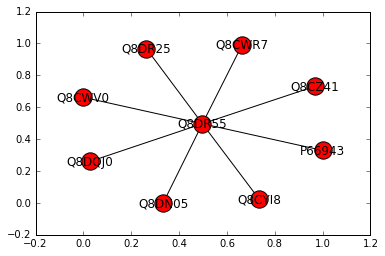

In [128]:
G = drawGraph(queryTopo)
#test = deserializeGraph("/Users/mbachir/Desktop/omegaLoMo/testGraph/Q8DR55.json")
plt.show(G)